In [1]:
from google.colab import drive 
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

Order_UpTo_Level(SKU, ТТ) - политика пополнения (S)
<br>ReOrder_Level(SKU, ТТ) - политика пополнения (s)
<br>(Возможное представление — Dataframe)

In [0]:
OUL = 1 # Order Upto Level
ROL = 0 # Re-Order Level
Delta = OUL - ROL # Delta = Order_UpTo_Level - ReOrder_Level (S-s)

# Восстановление спроса на тестовых данных



Используем обучающие данные из файла data.zip, чтобы научиться восстанавливать спрос.

In [0]:
sales = pd.read_csv('/content/gdrive/My Drive/A Reinforcement Learning Approach for Inventory Optimization in Retail/DemandRestoring_v0/data/sales_4001.csv', sep=',', decimal='.')
sales['Timestamp'] = pd.to_datetime(sales[u'purchase_date'])
sales = sales.set_index(['Timestamp'], drop=True).rename(columns={'quantity':'sales'})
sales.head()

,purchase_date,shop_id,product_id,price,sales,price_after_discount
Timestamp,,,,,,
2013-01-02,2013-01-02,4001,4100024369,1480,1,1480.0
2013-01-02,2013-01-02,4001,4100024794,2807,1,2807.0
2013-01-02,2013-01-02,4001,4100028657,979,1,979.0
2013-01-02,2013-01-02,4001,4300000205,3319,1,3319.0
2013-01-02,2013-01-02,4001,4300007581,1899,1,1899.0


In [0]:
inventory = pd.read_csv('/content/gdrive/My Drive/A Reinforcement Learning Approach for Inventory Optimization in Retail/DemandRestoring_v0/data/remains_4001.csv', sep=',', decimal='.')
inventory['Timestamp'] = pd.to_datetime(inventory[u'updated_at'])
inventory = inventory.set_index(['Timestamp'], drop=True).rename(columns={'quantity':'inventory'})
# inventory = inventory.sort_index()
inventory.head()

,shop_id,product_id,updated_at,inventory
Timestamp,,,,
2015-08-31,4001,4300059161,2015-08-31,0
2016-01-02,4001,4300059161,2016-01-02,0
2015-08-31,4001,4300059161,2015-08-31,1
2013-04-17,4001,4300051009,2013-04-17,1
2013-08-11,4001,4300051009,2013-08-11,0


В качестве списка всех магазинов и товаров используем информацию об остатках, так как при наличии записи о ненулевом остатке в inventory можно говорить об нулевых продажах в sales.

In [0]:
shops = np.sort(inventory['shop_id'].unique())
print(len(shops), shops)

products = np.sort(inventory['product_id'].unique())
print(len(products), products)

1 [4001]
14466 [4100000013 4100000017 4100000029 ... 4900005059 4900005473 4900005475]


Для каждого товара в каждом магазине расчитаем lambda.



In [0]:
lambda_data = pd.DataFrame(columns=['shop_id', 'product_id', 'month', 'lambda'])
lambda_data

,shop_id,product_id,month,lambda


In [0]:
shop_id = 4001
product_id = 4100000013

# inventory = inventory[(inventory['product_id'] == product_id) & (inventory['shop_id'] == shop_id)]
# inventory[(inventory['product_id'] == product_id) & (inventory['shop_id'] == shop_id)]

# Агрегируем на всякий случай остатки на одну дату (берём максимально известный остаток за дату)
iv_ts = inventory.reset_index().groupby('Timestamp').agg({'inventory':np.max})

# Добавим пропущенные даты и заполним значения остатков в эти даты нулями
iv_ts = iv_ts.reindex(pd.date_range(np.min(iv_ts.index), np.max(iv_ts.index))).fillna(method='ffill')

# Добавим данные о продажах
sales_ts = sales[(sales['product_id'] == product_id) & (sales['shop_id'] == shop_id)]

# Объединим продажи и остатки в один датафрейм
iv_sales = sales_ts[['sales']].merge(iv_ts, how='right', left_index=True, right_index=True)
iv_sales['sales'].fillna(0, inplace=True)

# Удалим начало и "хвост" истории, когда продажи и остатки были равны нулю
positive_iv_sales = iv_sales[iv_sales.max(axis=1) > 0]
life_start_date = positive_iv_sales.index[0]
life_end_date = positive_iv_sales.index[-1]
iv_sales = iv_sales[(iv_sales.index >= life_start_date) & (iv_sales.index <= life_end_date)] 

# Дни, когда и остатки и продажи = нулю
zero_idx = (iv_sales['inventory'] == 0) & (iv_sales['sales'] == 0)
# Дни, когда продажи = остаткам
sales_equal_inv_idx = (iv_sales['inventory'] == iv_sales['sales']) 
# Дни, когда продажи >= остаткам
sales_greater_i_idx = (iv_sales['inventory'] <= iv_sales['sales']) 

# Суммарные продажи товара в данном магазине
sum_k = iv_sales['sales'].sum()
# Количество дней, когда продажи были меньше остатка
n_k_less_m = iv_sales['sales'][(~zero_idx) & (~sales_greater_i_idx)].count()
# Количество дней, когда продажи были равны остатку (все распродано)
n_k_equal_m = iv_sales['sales'][(~zero_idx) & sales_greater_i_idx].count()

alpha = 1
LAMBDA = sum_k / (n_k_less_m + alpha * n_k_equal_m)

print('sum_k: ', sum_k)
print('n_k_less_m: ', n_k_less_m)
print('n_k_equal_m: ', n_k_equal_m)
print('LAMBDA:', LAMBDA)

sum_k:  1.0
n_k_less_m:  179
n_k_equal_m:  1
LAMBDA: 0.005555555555555556


In [0]:
def kernel_default(x, y):
    return 1

In [0]:
def DemandRestoring(shop_id, product_id, kernel=kernel_default):
    # inventory = inventory[(inventory['product_id'] == product_id) & (inventory['shop_id'] == shop_id)]
    # inventory[(inventory['product_id'] == product_id) & (inventory['shop_id'] == shop_id)]

    # Агрегируем на всякий случай остатки на одну дату (берём максимально известный остаток за дату)
    iv_ts = inventory.reset_index().groupby('Timestamp').agg({'inventory':np.max})

    # Добавим пропущенные даты и заполним значения остатков в эти даты нулями
    iv_ts = iv_ts.reindex(pd.date_range(np.min(iv_ts.index), np.max(iv_ts.index))).fillna(method='ffill')

    # Добавим данные о продажах
    sales_ts = sales[(sales['product_id'] == product_id) & (sales['shop_id'] == shop_id)]

    # Объединим продажи и остатки в один датафрейм
    iv_sales = sales_ts[['sales']].merge(iv_ts, how='right', left_index=True, right_index=True)
    iv_sales['sales'].fillna(0, inplace=True)

    # Удалим начало и "хвост" истории, когда продажи и остатки были равны нулю
    positive_iv_sales = iv_sales[iv_sales.max(axis=1) > 0]
    life_start_date = positive_iv_sales.index[0]
    life_end_date = positive_iv_sales.index[-1]
    iv_sales = iv_sales[(iv_sales.index >= life_start_date) & (iv_sales.index <= life_end_date)] 

    # Дни, когда и остатки и продажи = нулю
    zero_idx = (iv_sales['inventory'] == 0) & (iv_sales['sales'] == 0)
    # Дни, когда продажи = остаткам
    sales_equal_inv_idx = (iv_sales['inventory'] == iv_sales['sales']) 
    # Дни, когда продажи >= остаткам
    sales_greater_i_idx = (iv_sales['inventory'] <= iv_sales['sales']) 




#     # вычисление веса для каждого периода, когда наблюдался дефицит 
#     iv_sales['LAMBDA'] = np.NaN
#     for oos_day in zero_idx:
#         iv_sales['weights'] = [kernel(iv_sales.index[oos_day], iv_sales.index[x]) for x in iv_sales.index] 

#         # Суммарные продажи товара в данном магазине
#         iv_sales['scalar'] = iv_sales['sales'][(~zero_idx)]*iv_sales['weights'][(~zero_idx)]
#         sum_k = iv_sales['scalar'].sum()
        
#         #   sum_k = iv_sales['sales'].sum()
#         # Количество дней, когда продажи были меньше остатка
# #         n_k_less_m = iv_sales['sales'][(~zero_idx) & (~sales_greater_i_idx)].count()
#         n_k_less_m = iv_sales['weights'][(~zero_idx) & (~sales_greater_i_idx)].sum()
#         # Количество дней, когда продажи были равны остатку (все распродано)
# #         n_k_equal_m = iv_sales['sales'][(~zero_idx) & sales_greater_i_idx].count()
#         n_k_equal_m = iv_sales['weights'][(~zero_idx) & sales_greater_i_idx].sum()

#         alpha = 1 # Возможно проапгрейдить
#         iv_sales['LAMBDA'][oss_day] = sum_k / (n_k_less_m + alpha * n_k_equal_m)




    lambda_data_t = pd.DataFrame(columns=['shop_id', 'product_id', 'month', 'lambda'])

    # вычисление веса для каждого периода, когда наблюдался дефицит
    iv_sales['LAMBDA'] = np.NaN
    for oos_day in zero_idx.index:
        # iv_sales['weights'] = [kernel(iv_sales.index[oos_day], iv_sales.index[x]) for x in iv_sales.index]
        iv_sales['weights'] = [kernel(oos_day.month, x.month) for x in iv_sales.index]
        # iv_sales['weights'] = [1 for x in iv_sales.index]

        # Суммарные продажи товара в данном магазине
        iv_sales['scalar'] = iv_sales['sales'][(~zero_idx)] * iv_sales['weights'][(~zero_idx)]
        sum_k = iv_sales['scalar'].sum()
        
        # Количество дней, когда продажи были меньше остатка
        n_k_less_m = iv_sales['weights'][(~zero_idx) & (~sales_greater_i_idx)].sum()

        # Количество дней, когда продажи были равны остатку (все распродано)
        n_k_equal_m = iv_sales['weights'][(~zero_idx) & sales_greater_i_idx].sum()

        alpha = 1 # Возможно проапгрейдить
        LAMBDA = sum_k / (n_k_less_m + alpha * n_k_equal_m)

        lambda_data_t = lambda_data_t.append({'shop_id': shop_id, 'product_id': product_id, 'month': oos_day.month, 'lambda': LAMBDA}, ignore_index=True)

    return lambda_data_t

In [0]:
lambda_data_t = DemandRestoring(4001, 4100000013).drop_duplicates()
lambda_data_t

,shop_id,product_id,month,lambda
0,4001.0,4.100000e+09,1.0,0.005556
1,4001.0,4.100000e+09,1.0,0.005556
2,4001.0,4.100000e+09,1.0,0.005556
3,4001.0,4.100000e+09,1.0,0.005556
4,4001.0,4.100000e+09,1.0,0.005556
...,...,...,...,...
1367,4001.0,4.100000e+09,10.0,0.005556
1368,4001.0,4.100000e+09,10.0,0.005556
1369,4001.0,4.100000e+09,10.0,0.005556
1370,4001.0,4.100000e+09,10.0,0.005556


In [0]:
for shop_id in shops:
    for product_id in products:
        lambda_data_t = DemandRestoring(shop_id, product_id).drop_duplicates()
        lambda_data = lambda_data.append(lambda_data_t)

In [0]:
lambda_data[['shop_id', 'product_id', 'month']] = lambda_data[['shop_id', 'product_id', 'month']].astype('int64')
lambda_data['lambda'] = lambda_data['lambda'].astype('float64')
lambda_data

In [0]:
export_lambda_csv = lambda_data.to_csv('/content/gdrive/My Drive/A Reinforcement Learning Approach for Inventory Optimization in Retail/DemandRestoring_v0/data/lambda_data.csv', sep=',', decimal='.')

Можно сразу подгрузить посчитанную lambda.

In [0]:
lambda_data = pd.read_csv('/content/gdrive/My Drive/A Reinforcement Learning Approach for Inventory Optimization in Retail/DemandRestoring_v0/data/lambda_data.csv')
lambda_data

,Unnamed: 0,shop_id,product_id,month,lambda
0,0,4001,4100000013,1,0.005556
1,1,4001,4100000017,1,0.005587
2,2,4001,4100000029,1,0.000000
3,3,4001,4100000137,1,0.005556
4,4,4001,4100000170,1,0.005556
...,...,...,...,...,...
14461,14461,4001,4900005055,1,0.000000
14462,14462,4001,4900005057,1,0.000000
14463,14463,4001,4900005059,1,0.000000
14464,14464,4001,4900005473,1,0.000000


# Восстановление спроса на MERGE_TABLE_STORE_4600

In [0]:
MERGE_TABLE_STORE_4600 = pd.read_csv('/content/gdrive/My Drive/A Reinforcement Learning Approach for Inventory Optimization in Retail/MERGE_TABLE_STORE_4600/MERGE_TABLE_STORE_4600.csv', sep=';', decimal='.')
MERGE_TABLE_STORE_4600['Timestamp'] = pd.to_datetime(MERGE_TABLE_STORE_4600['curr_date'], format='%d%b%Y')
MERGE_TABLE_STORE_4600['curr_date'] = MERGE_TABLE_STORE_4600['Timestamp']
MERGE_TABLE_STORE_4600 = MERGE_TABLE_STORE_4600.set_index(['Timestamp'], drop=True)
MERGE_TABLE_STORE_4600

,product_id,store_id,curr_date,s_qty,flg_spromo,stock
Timestamp,,,,,,
2016-02-01,200,4600,2016-02-01,NaN,0,2.0
2016-02-02,200,4600,2016-02-02,NaN,0,2.0
2016-02-03,200,4600,2016-02-03,NaN,0,2.0
2016-02-04,200,4600,2016-02-04,NaN,0,2.0
2016-02-05,200,4600,2016-02-05,NaN,0,2.0
...,...,...,...,...,...,...
2019-10-31,20042700,4600,2019-10-31,0.0,0,NaN
2019-11-01,20042700,4600,2019-11-01,NaN,0,1.0
2019-11-02,20042700,4600,2019-11-02,NaN,0,1.0


In [0]:
shops_4600 = np.sort(MERGE_TABLE_STORE_4600['store_id'].unique())
print(len(shops_4600), shops_4600)

products_4600 = np.sort(MERGE_TABLE_STORE_4600['product_id'].unique())
print(len(products_4600), products_4600)

dates_4600 = pd.date_range(start=MERGE_TABLE_STORE_4600['curr_date'].min(), end=MERGE_TABLE_STORE_4600['curr_date'].max())
print(len(dates_4600), dates_4600)

1 [4600]
12554 [     200      400      500 ... 20030100 20042700 20051800]
1460 DatetimeIndex(['2016-01-01', '2016-01-02', '2016-01-03', '2016-01-04',
               '2016-01-05', '2016-01-06', '2016-01-07', '2016-01-08',
               '2016-01-09', '2016-01-10',
               ...
               '2019-12-21', '2019-12-22', '2019-12-23', '2019-12-24',
               '2019-12-25', '2019-12-26', '2019-12-27', '2019-12-28',
               '2019-12-29', '2019-12-30'],
              dtype='datetime64[ns]', length=1460, freq='D')


In [0]:
def kernel_default(x, y):
    return 1

In [0]:
def DemandRestoring(shop_id, product_id, kernel=kernel_default):
    # Агрегируем на всякий случай остатки на одну дату (берём максимально известный остаток за дату)
    iv_ts = MERGE_TABLE_STORE_4600.reset_index().groupby('Timestamp').agg({'stock':np.max})

    # Добавим пропущенные даты и заполним значения остатков в эти даты нулями
    iv_ts = iv_ts.reindex(pd.date_range(np.min(iv_ts.index), np.max(iv_ts.index))).fillna(method='ffill')

    # Добавим данные о продажах
    sales_ts = MERGE_TABLE_STORE_4600[(MERGE_TABLE_STORE_4600['product_id'] == product_id) & (MERGE_TABLE_STORE_4600['store_id'] == shop_id)]

    # Объединим продажи и остатки в один датафрейм
    iv_sales = sales_ts[['s_qty']].merge(iv_ts, how='right', left_index=True, right_index=True)

    # Удалим начало и "хвост" истории, когда продажи и остатки были равны нулю
    positive_iv_sales = iv_sales[iv_sales.max(axis=1) > 0]
    life_start_date = positive_iv_sales.index[0]
    life_end_date = positive_iv_sales.index[-1]
    iv_sales = iv_sales[(iv_sales.index >= life_start_date) & (iv_sales.index <= life_end_date)] 

    # Дни, когда и остатки и продажи = нулю
    zero_idx = (iv_sales['stock'] == 0) & (iv_sales['s_qty'] == 0)
    # Дни, когда продажи = остаткам
    sales_equal_inv_idx = (iv_sales['stock'] == iv_sales['s_qty']) 
    # Дни, когда продажи >= остаткам
    sales_greater_i_idx = (iv_sales['stock'] <= iv_sales['s_qty']) 

    lambda_data_t = pd.DataFrame(columns=['shop_id', 'product_id', 'month', 'lambda'])

    # вычисление веса для каждого периода, когда наблюдался дефицит
    iv_sales['LAMBDA'] = np.NaN
    for oos_day in zero_idx.index:
        # iv_sales['weights'] = [kernel(iv_sales.index[oos_day], iv_sales.index[x]) for x in iv_sales.index]
        iv_sales['weights'] = [kernel(oos_day.month, x.month) for x in iv_sales.index]
        # iv_sales['weights'] = [1 for x in iv_sales.index]

        # Суммарные продажи товара в данном магазине
        iv_sales['scalar'] = iv_sales['s_qty'][(~zero_idx)] * iv_sales['weights'][(~zero_idx)]
        sum_k = iv_sales['scalar'].sum()
        
        # Количество дней, когда продажи были меньше остатка
        n_k_less_m = iv_sales['weights'][(~zero_idx) & (~sales_greater_i_idx)].sum()

        # Количество дней, когда продажи были равны остатку (все распродано)
        n_k_equal_m = iv_sales['weights'][(~zero_idx) & sales_greater_i_idx].sum()

        alpha = 1 # Возможно проапгрейдить
        LAMBDA = sum_k / (n_k_less_m + alpha * n_k_equal_m)

        lambda_data_t = lambda_data_t.append({'shop_id': shop_id, 'product_id': product_id, 'month': oos_day.month, 'lambda': LAMBDA}, ignore_index=True)

    return lambda_data_t

In [0]:
lambda_data_4600_t = DemandRestoring(4600, 200).drop_duplicates()
lambda_data_4600_t

,shop_id,product_id,month,lambda
0,4600.0,200.0,1.0,0.006211
20,4600.0,200.0,2.0,0.006211
49,4600.0,200.0,3.0,0.006211
80,4600.0,200.0,4.0,0.006211
110,4600.0,200.0,5.0,0.006211
141,4600.0,200.0,6.0,0.006211
171,4600.0,200.0,7.0,0.006211
202,4600.0,200.0,8.0,0.006211
233,4600.0,200.0,9.0,0.006211
263,4600.0,200.0,10.0,0.006211


In [0]:
lambda_data_4600 = pd.DataFrame(columns=['shop_id', 'product_id', 'month', 'lambda'])

for shop_id in shops_4600:
    for product_id in products_4600:
    # for product_id in [200, 400, 500]:
        lambda_data_4600_t = DemandRestoring(shop_id, product_id).drop_duplicates()
        lambda_data_4600 = lambda_data_4600.append(lambda_data_4600_t)

In [0]:
lambda_data_4600

NameError: ignored

In [0]:
lambda_data_4600[['shop_id', 'product_id', 'month']] = lambda_data_4600[['shop_id', 'product_id', 'month']].astype('int64')
lambda_data_4600['lambda'] = lambda_data_4600['lambda'].astype('float64')
export_lambda_4600_csv = lambda_data_4600.to_csv('/content/gdrive/My Drive/A Reinforcement Learning Approach for Inventory Optimization in Retail/MERGE_TABLE_STORE_4600/lambda_data_4600.csv', sep=',', decimal='.')

In [0]:
lambda_data_4600 = pd.read_csv('/content/gdrive/My Drive/A Reinforcement Learning Approach for Inventory Optimization in Retail/MERGE_TABLE_STORE_4600/lambda_data_4600.csv', sep=',', decimal='.')

In [0]:
lambda_data_4600.head()

,shop_id,product_id,month,lambda
0,4600,200,1,0.006211
20,4600,200,2,0.006211
49,4600,200,3,0.006211
80,4600,200,4,0.006211
110,4600,200,5,0.006211


# Reward

Service Level:

In [0]:
sl_data = pd.read_csv('/content/gdrive/My Drive/A Reinforcement Learning Approach for Inventory Optimization in Retail/MERGE_TABLE_STORE_4600/data/echelon/echelon_1_sl.csv', sep=';')
sl_data['date_from'] = pd.to_datetime(sl_data['date_from'], format='%d%b%Y')
sl_data['date_to'] = pd.to_datetime(sl_data['date_to'], format='%d%b%Y')
sl_data

,date_from,date_to,product_ids,location_ids,value
0,2019-05-18,2019-05-19,200,16500,0.81
1,2019-05-20,2019-05-20,200,16500,0.90
2,2019-05-21,2019-05-21,200,16500,0.81
3,2019-05-22,2019-05-22,200,16500,0.95
4,2019-05-24,2019-06-10,200,16500,0.81
...,...,...,...,...,...
2893689,2019-06-26,2019-06-26,19907000,357900,0.45
2893690,2019-06-26,2019-06-26,19907000,364400,0.45
2893691,2019-06-26,2019-06-26,19907000,375700,0.45
2893692,2019-06-26,2019-06-26,19907000,411200,0.45


In [0]:
products_echelon_1 = np.sort(sl_data['product_ids'].unique())
print(len(products_echelon_1), products_echelon_1)

locations_echelon_1 = np.sort(sl_data['location_ids'].unique())
print(len(locations_echelon_1), locations_echelon_1)

dates_echelon_1 = pd.date_range(start=sl_data['date_from'].min(), end=sl_data['date_to'].max())
print(len(dates_echelon_1), dates_echelon_1)

9089 [     200      500      800 ... 19902400 19902500 19907000]
59 [  4600  16500  22800  32700  34000  34800  35200  42500  43400  44400
 132100 136300 136500 140400 140600 140800 145200 146100 147000 181000
 183300 185200 185300 191000 193400 193800 199100 201700 202000 210400
 211800 223500 223600 230900 243300 357900 358400 359200 360400 360900
 363600 364400 364900 365000 366600 375400 375700 376200 385200 411200
 412000 412300 422700 425000 430000 431000 436900 465600 497200]
40 DatetimeIndex(['2019-05-18', '2019-05-19', '2019-05-20', '2019-05-21',
               '2019-05-22', '2019-05-23', '2019-05-24', '2019-05-25',
               '2019-05-26', '2019-05-27', '2019-05-28', '2019-05-29',
               '2019-05-30', '2019-05-31', '2019-06-01', '2019-06-02',
               '2019-06-03', '2019-06-04', '2019-06-05', '2019-06-06',
               '2019-06-07', '2019-06-08', '2019-06-09', '2019-06-10',
               '2019-06-11', '2019-06-12', '2019-06-13', '2019-06-14',
            

In [0]:
reward = 0

for shop_id in [shop for shop in shops_4600 if shop in locations_echelon_1]:
    for product_id in [prod for prod in products_4600 if prod in products_echelon_1]:
    # for product_id in [18973900]:

        store_sales_t = MERGE_TABLE_STORE_4600[MERGE_TABLE_STORE_4600['store_id']==shop_id]
        store_sales_t = store_sales_t[store_sales_t['product_id']==product_id].fillna(0)

        sl_data_t = sl_data.set_index(['date_from'], drop=True)
        sl_data_t = sl_data_t[sl_data_t['location_ids']==shop_id]
        sl_data_t = sl_data_t[sl_data_t['product_ids']==product_id]

        if not sl_data_t.empty:

            # Дополнительная обработка пропусков в sl_data_t
            all_days = pd.date_range(start=sl_data_t.index.min(), end=sl_data_t['date_to'].max())
            sl_data_t.index = pd.DatetimeIndex(sl_data_t.index)
            sl_data_t = sl_data_t.reindex(all_days, method='ffill')
            sl_data_t = sl_data_t.drop(columns=['date_to'])

            r = (store_sales_t['s_qty'] - store_sales_t['stock'] * (1 - sl_data_t['value']) / sl_data_t['value']).sum()
            reward += r

print('reward =', reward)

reward = -151099.16302236047


# Остальные составляющие среды

Order(SKU, ТТ)_t - это количество товаров,отправка которого инициировано соответствующим Recommended_Order(SKU, ТТ)_t, которое финально доедет и будет выставлено на полку в магазин.

Order(SKU, ТТ)_t и Recommended_Order_t в этих обозначениях _t - дата, когда сформировались данные объёмы.

State: (Stock(SKU, ТТ)_j, Sales(SKU, ТТ)_j, Demand(SKU, ТТ)_j, Orders_Pipeline(SKU, ТТ): [Order_t, Ordrer_t-n, Order_t-m, Order_t-p], n<m<p) period t1-t2

Хранить Stock, Sales и Demand как dataframe?

LT = 1

Важно: в State продаж (Sales) и остатки (Stock) - модельные (нужно моделировать. Те, Sales и Stock, что пришли в данных от заказчика (как результат работы реальной системы) - нужны только для восстановления спрос

In [0]:
sales_data = pd.DataFrame(columns=['purchase_date', 'shop_id', 'product_id', 'price', 'sales'])
stock_data = pd.DataFrame(columns=['updated_at', 'shop_id', 'product_id', 'stock'])
recommended_order_data = pd.DataFrame(columns=['updated_at', 'shop_id', 'product_id', 'value'])
order_data = pd.DataFrame(columns=['updated_at', 'shop_id', 'product_id', 'value'])

*   Demand(SKU)_t = F(Sales_all_data, Inv_all_history)
*   Моделирование Sales_t = MAX(Demand_t, Inv_{t-1}+Orders_{t-LT+})
*   Моделирование Inv_t = MAX(Inv_{t-1} + Orders_{t-LT+} - Demand_t, 0)

In [0]:
def sales_update(date, shop_id, product_id, price):
    LT = 1
    sales_data_t = pd.DataFrame(columns=['purchase_date', 'shop_id', 'product_id', 'price', 'sales'])

    sales = max(demand_data[demand_data['shop_id']==shop_id][demand_data['product_id']==product_id].demand, stock_data[stock_data['shop_id']==shop_id][stock_data['product_id']==product_id].iloc[-1].stock
                + order_data[order_data['shop_id']==shop_id][order_data['product_id']==product_id].iloc[-1-LT].value)
    price = sales_data[sales_data['shop_id']==shop_id][sales_data['product_id']==product_id].iloc[-1].price
    sales_data_t = sales_data_t.append({'purchase_date': date, 'shop_id': shop_id, 'product_id': product_id, 'price': price, 'sales': sales}, ignore_index=True)

    return sales_data_t

In [0]:
def stock_update(date, shop_id, product_id):
    LT = 1
    stock_data_t = pd.DataFrame(columns=['updated_at', 'shop_id', 'product_id', 'stock'])

    stock = max(stock_data[stock_data['shop_id']==shop_id][stock_data['product_id']==product_id].iloc[-1].stock
                + order_data[order_data['shop_id']==shop_id][order_data['product_id']==product_id].iloc[-1-LT].value
                - demand_data[demand_data['shop_id']==shop_id][demand_data['product_id']==product_id].demand, 0)

    stock_data_t = stock_data_t.append({'updated_at': date, 'shop_id': shop_id, 'product_id': product_id, 'stock': stock}, ignore_index=True)

    return stock_data_t

Рекомендация к заказу: Recommend_Order_t = OUL - (INV + Orders_t - 1), IF Inv_t <= ROL 0, otherwise.

recommend_order - наша рекомендация к заказу
<br>order - объем получаемого заказа

order = F(recommend_order_t, alpha_order)
<br>1)order <= recommend_order_t 
<br>2)$\sum_{sku}$ E(order_{sku,t}) = alpha_order * E(recommend_order_{sku,t})

inv[t] = max(inv[t - 1] + order_come[t] - demand(m), 0)
<br>sales = max(demand(m), inv[t - 1] + order_come[t])

In [0]:
def rec_order_update(date, shop_id, product_id):
    recommended_order_data_t = pd.DataFrame(columns=['updated_at', 'shop_id', 'product_id', 'value'])

    if stock(shop_id, product_id) <= ROL:
        value = OUL - stock_data[stock_data['shop_id']==shop_id][stock_data['product_id']==product_id].iloc[-1].stock - order_data[order_data['shop_id']==shop_id][order_data['product_id']==product_id].iloc[-1].value
        recommended_order_data_t = recommended_order_data_t.append({'updated_at': date, 'shop_id': shop_id, 'product_id': product_id, 'value': value}, ignore_index=True)
    else:
        recommended_order_data_t = recommended_order_data_t.append({'updated_at': date, 'shop_id': shop_id, 'product_id': product_id, 'value': 0}, ignore_index=True)

    return recommended_order_data_t

In [0]:
def order_update(date, shop_id, product_id):
    alpha_order = 0.3
    order_data_t = pd.DataFrame(columns=['updated_at', 'shop_id', 'product_id', 'value'])

    # value = ceil(np.random.uniform(rec_order * alpha_order, rec_order))
    order_data_t = order_data_t.append({'updated_at': date, 'shop_id': shop_id, 'product_id': product_id, 'value': value}, ignore_index=True)

    return order_data_t

In [0]:
from scipy import stats

# Uniform Distribution -- mu=(a+b-1)/2
def order_update0(rec_order, alpha_order):
    return np.random.uniform(rec_order * alpha_order, rec_order)

# # Poisson Distribution -- mu=lambda
# def order_update1(rec_order, alpha_order):
#     return np.random.poisson(rec_order * alpha_order)

# Poisson Distribution -- mu=lambda
def order_update1(rec_order, alpha_order):
    return np.min([np.random.poisson(rec_order * alpha_order), rec_order], axis=0)

# Binomial Distribution -- mu=n*p
def order_update2(rec_order, alpha_order):
    return np.random.binomial(n=rec_order, p=alpha_order)

# Negative Binomial Distribution -- mu=n(1-p)/p
def order_update3(rec_order, alpha_order):
    return np.random.negative_binomial(n=rec_order, p=1 - alpha_order)

# Negative Binomial Distribution -- mu=n(1-p)/p
def order_update4(rec_order, alpha_order):
    return np.min([np.random.negative_binomial(n=rec_order, p=1 - alpha_order), rec_order], axis=0)

# Beta-Binomial Distribution -- mu=n*a/(a+b)
def order_update5(rec_order, alpha_order):
    return stats.betabinom.rvs(n=rec_order, a=alpha_order * rec_order, b=rec_order)


# realization = [order_update5(rec_order=1, alpha_order=0.3) for x in range(10000)]
# plt.hist(realization)
# print(np.mean(realization))

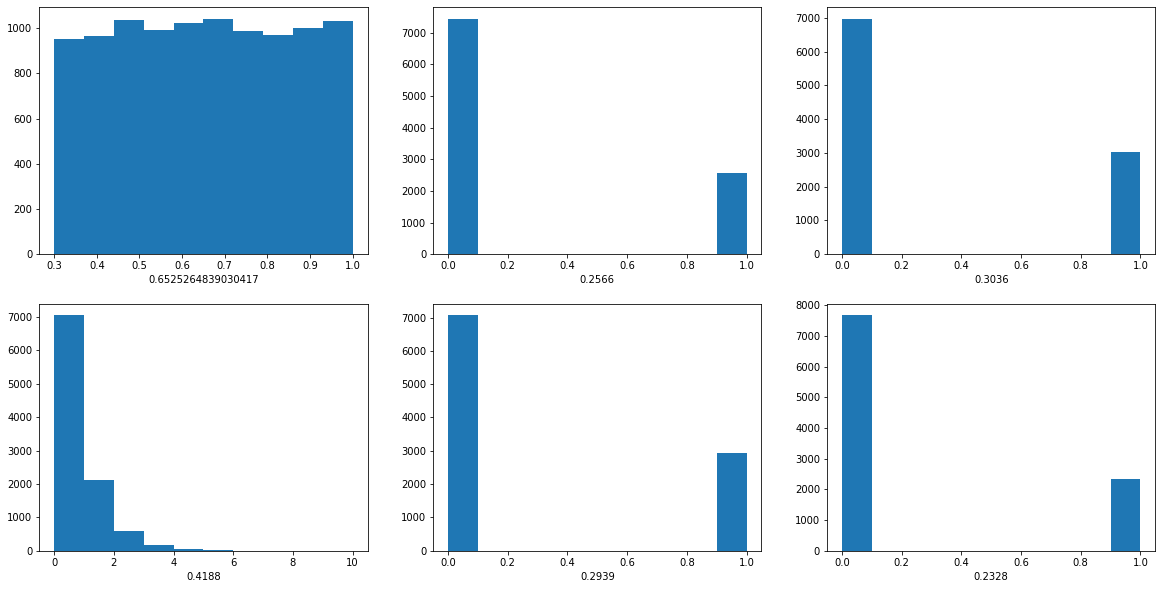

In [31]:
rec_order = 1
alpha_order = 0.3

realization0 = [order_update0(rec_order, alpha_order) for x in range(10000)]    # Uniform Distribution                          -- mu=(a+b-1)/2
realization1 = [order_update1(rec_order, alpha_order) for x in range(10000)]    # Poisson Distribution with np.min              -- mu=lambda
realization2 = [order_update2(rec_order, alpha_order) for x in range(10000)]    # Binomial Distribution                         -- mu=n*p
realization3 = [order_update3(rec_order, alpha_order) for x in range(10000)]    # Negative Binomial Distribution                -- mu=n(1-p)/p
realization4 = [order_update4(rec_order, alpha_order) for x in range(10000)]    # Negative Binomial Distribution with np.min    -- mu=n(1-p)/p
realization5 = [order_update5(rec_order, alpha_order) for x in range(10000)]    # Beta-Binomial Distribution                    -- mu=n*a/(a+b)

plt.figure(figsize=(20, 10))
for i, real in enumerate([realization0, realization1, realization2, realization3, realization4, realization5]):
    plt.subplot(2, 3, i + 1)
    plt.hist(real)
    plt.xlabel(np.mean(real))

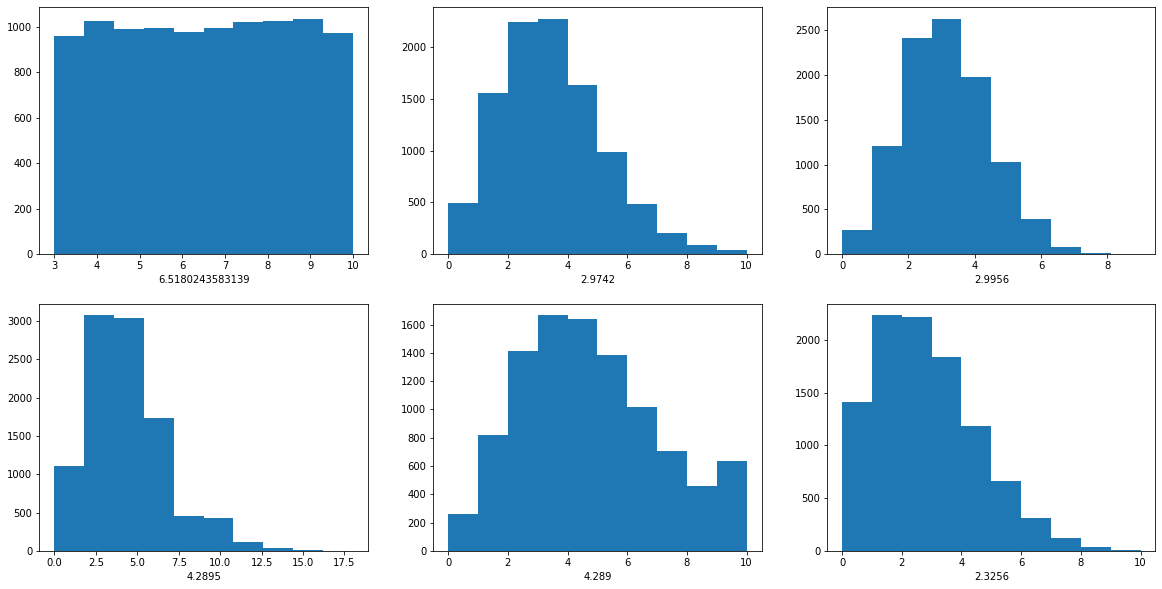

In [33]:
rec_order = 10
alpha_order = 0.3

realization0 = [order_update0(rec_order, alpha_order) for x in range(10000)]    # Uniform Distribution                          -- mu=(a+b-1)/2
realization1 = [order_update1(rec_order, alpha_order) for x in range(10000)]    # Poisson Distribution with np.min              -- mu=lambda
realization2 = [order_update2(rec_order, alpha_order) for x in range(10000)]    # Binomial Distribution                         -- mu=n*p
realization3 = [order_update3(rec_order, alpha_order) for x in range(10000)]    # Negative Binomial Distribution                -- mu=n(1-p)/p
realization4 = [order_update4(rec_order, alpha_order) for x in range(10000)]    # Negative Binomial Distribution with np.min    -- mu=n(1-p)/p
realization5 = [order_update5(rec_order, alpha_order) for x in range(10000)]    # Beta-Binomial Distribution                    -- mu=n*a/(a+b)

plt.figure(figsize=(20, 10))
for i, real in enumerate([realization0, realization1, realization2, realization3, realization4, realization5]):
    plt.subplot(2, 3, i + 1)
    plt.hist(real)
    plt.xlabel(np.mean(real))